# Hyperparameter Tuning, Training, Results

In [1]:
%reset -f

import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import re
import optuna
import joblib

from utils import split_time_series
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)


/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Read data from the preprocessed data
data_sales = pd.read_pickle('data/data_sales_01.pickle')

In [3]:
data_sales.shape

(11128004, 38)

In [4]:
drop_cols_fit = ["target"]
dates = data_sales['date_block_num']

Hyperparameter Tuning based on Grid search using optuna.
Hyperparameters to be tuned
- **eta** learning rate of boosting
- **max_depth**: max_depth of individual of trees
- **min_child_weight**: Minimum weight imposed on child of each node, increasing this will be decrease the complexity of the model
- **colsample_bytree**: Sampling ratio of features, decreaseing this parameter will decrease the variance of the model
- **subsample**: Sampling ratio of data set points, decreaseing this parameter will decrease the the variance of the model

In [5]:
from sklearn.metrics import mean_squared_error

# Values of the hyperparameters to be searched
search_space = {
    'n_estimators': [300],
    'eta': [0.01, 0.03, 0.1, 0.3],
    'max_depth': [7, 9, 11, 13],
    'min_child_weight': [0.6, 1.2],
    'colsample_bytree': [0.6, 0.8], 
    'subsample':[0.6, 0.8], 
}


def objective_hyperparam(trial):

    # Dictionary to map from parameter name to values
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 300, 301),
        'eta': trial.suggest_float("eta", 0.01, 0.9, log=True),
        'max_depth': trial.suggest_int("max_depth", 7, 15, step=1),
        'min_child_weight': trial.suggest_float("min_child_weight", 0.3, 1.2, step=0.3),
        'eval_metric': ['rmse'],
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.4, 0.8, step=0.2), 
        'subsample':trial.suggest_float("subsample", 0.4, 0.8, step=0.2), 
        'early_stopping_rounds': 15,
        'seed': 42,
        'verbose' : False,
    }
    
    # XGboost model
    model = XGBRegressor(
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        min_child_weight=params['min_child_weight'], 
        colsample_bytree=params['colsample_bytree'], 
        subsample=params['subsample'], 
        eta=params['eta'],
        tree_method='gpu_hist',
        seed=params['seed'],
        n_jobs=4)
    
    split_num = 5
    
    total_score = 0

    # Calculate score of model by taking weighted average over 5 splits
    for i in range(split_num):
        #print(10*"*" + f"This is split {i}"+10*"*")
        val_idx = dates.max() - (i+1)
        start_idx = val_idx - 24
        X_train, X_val, y_train, y_val = split_time_series(data_sales, val_idx, drop_cols_fit, start_idx)
        # print((X_train.shape, X_val.shape, y_train.shape, y_val.shape))
        
        # Apply min-max normalization
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)

        model.fit(
            X_train, 
            y_train, 
            eval_metric=params["eval_metric"], 
            eval_set=[(X_train, y_train), (X_val,y_val)], 
            verbose=params['verbose'], 
            early_stopping_rounds = 10)


        # Predictions
        yhat_val = model.predict(X_val).clip(0,20)

        # RMSE for the predictions
        rmse = mean_squared_error(yhat_val, y_val, squared=False)
        
        total_score += rmse*(split_num-i)
    
    # Take the averegge
    total_score = total_score / (split_num*(split_num+1)/2)
    
    return total_score

In [6]:
# Study object to optimize objective_hyperparam function
# study_01 = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))
# study_01.optimize(objective_hyperparam)

I did hyperparameter search on Kaggle Kernels with their free GPUs, and saved the study object produced by this search to serialized file with joblib.
Its name is "study.pkl".

In [7]:
# joblib.dump(study, "data/study_01.pkl")

Now, we load the study object from disk and see the optimal values of hyperparameters

In [4]:
study_hyper = joblib.load('data/study_boost_00.pkl')

In [6]:
study_hyper.trials_dataframe().head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.850469 2022-03-22 13:19:50.541925 2022-03-22 13:21:57.620560   
1       1  0.842912 2022-03-22 13:21:57.622349 2022-03-22 13:25:56.745719   
2       2  0.843713 2022-03-22 13:25:56.747273 2022-03-22 13:29:59.099028   
3       3  0.838951 2022-03-22 13:29:59.101808 2022-03-22 13:33:01.589583   
4       4  0.828540 2022-03-22 13:33:01.591189 2022-03-22 13:38:24.841907   
5       5  0.831749 2022-03-22 13:38:24.843464 2022-03-22 13:51:51.676296   
6       6  0.843369 2022-03-22 13:51:51.677915 2022-03-22 13:57:59.676366   
7       7  0.831566 2022-03-22 13:57:59.678287 2022-03-22 14:05:35.065736   
8       8  0.831224 2022-03-22 14:05:35.067318 2022-03-22 14:10:50.928311   
9       9  0.833885 2022-03-22 14:10:50.929879 2022-03-22 14:13:29.105922   

                duration  params_colsample_bytree  params_eta  \
0 0 days 00:02:07.078635                      0.6        0.30   
1 0 days 00:03:59.123370                      0.8        0.03   
2 0 days 00:04:02.351755                      0.6        0.03   
3 0 days 00:03:02.487775                      0.8        0.10   
4 0 days 00:05:23.250718                      0.6        0.03   
5 0 days 00:13:26.832832                      0.6        0.01   
6 0 days 00:06:07.998451                      0.6        0.01   
7 0 days 00:07:35.387449                      0.8        0.03   
8 0 days 00:05:15.860993                      0.8        0.03   
9 0 days 00:02:38.176043                      0.6        0.10   

   params_max_depth  params_min_child_weight  params_n_estimators  \
0                13                      1.2                  300   
1                 7                      0.6                  300   
2                 7                      0.6                  300   
3                13                      1.2                  300   
4                11                      0.6                  300   
5                13                      0.6                  300   
6                 9                      1.2                  300   
7                13                      1.2                  300   
8                11                      0.6                  300   
9                11                      0.6                  300   

   params_subsample  system_attrs_grid_id  \
0               0.6                    62   
1               0.6                    80   
2               0.6                    16   
3               0.6                   110   
4               0.8                    25   
5               0.6                    12   
6               0.8                     7   
7               0.8                    95   
8               0.8                    89   
9               0.8                    41   

                           system_attrs_search_space     state  
0  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
1  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
2  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
3  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
4  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
5  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
6  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
7  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
8  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE  
9  {'colsample_bytree': [0.6, 0.8], 'eta': [0.01,...  COMPLETE

Now, lets visualize hyperparameter search

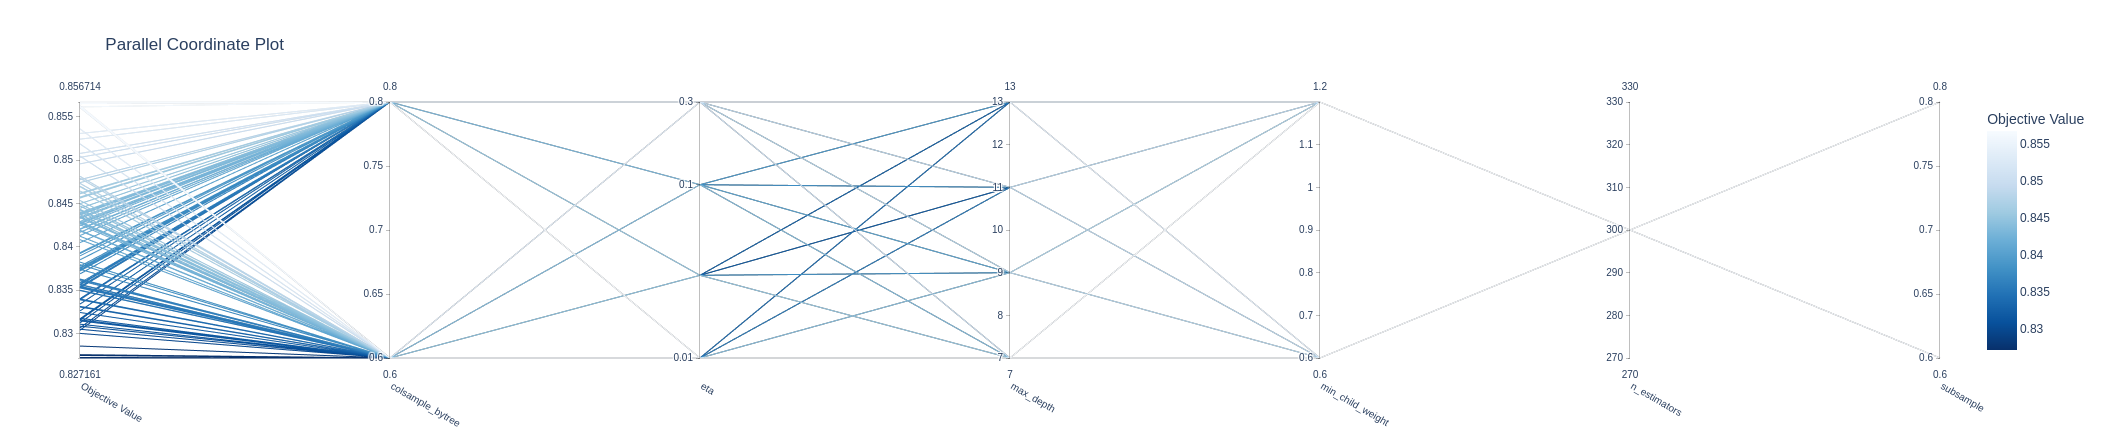

In [7]:
fig = plot_parallel_coordinate(study_hyper)
fig.update_layout(
    autosize=False,
    width=2100,
    height=440,)
fig.show()

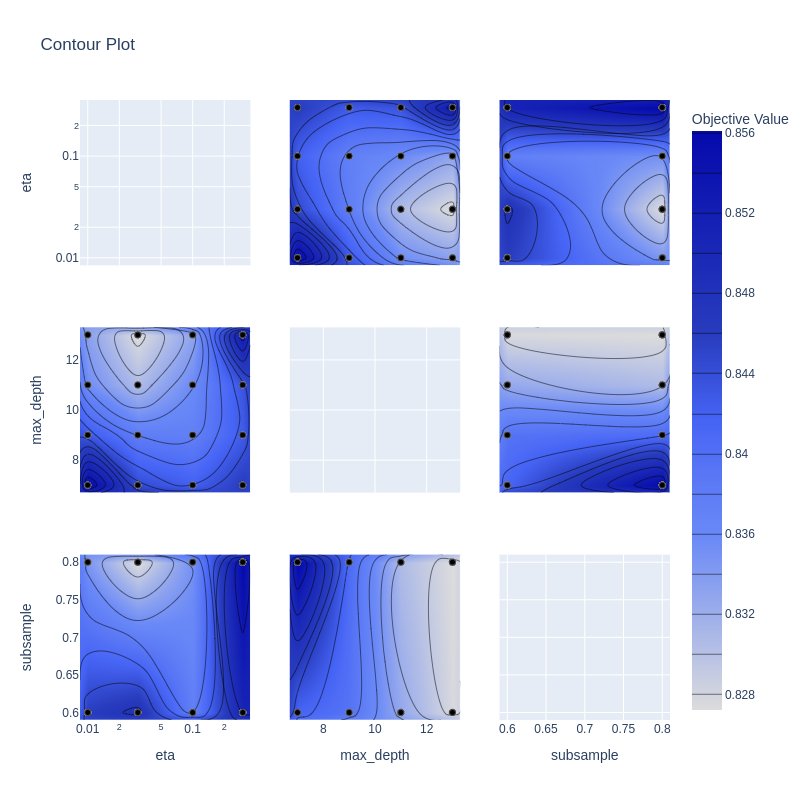

In [8]:
fig = plot_contour(study_hyper, params=['max_depth', 'eta', 'subsample'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

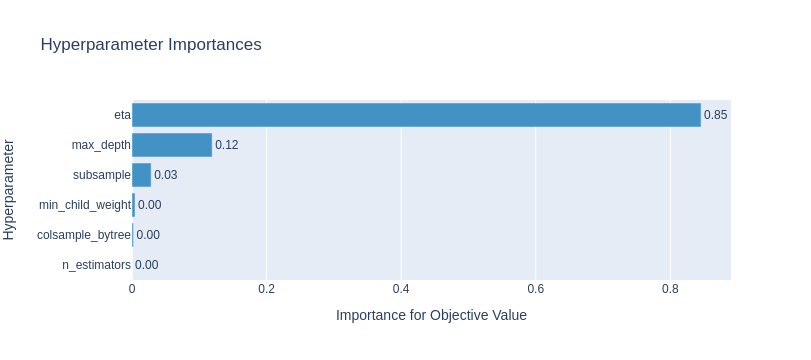

In [9]:
fig = optuna.visualization.plot_param_importances(study_hyper)
fig.show()

Now that we tuned our hyperparameters, we can use train our boosted tree model with these values and make predictions. I will use early stopping method, provided by xgboost api to prevent any potential overfitting.
Validation data will also respect the time splitting. To take full advantage of the full data, after training with early stopping, we will train our model once more, with validation data added to the training data for some number of steps. Note that the choice of number of steps is a bit arbitrary. I will choose so that it is low enough that there wont any overfitting and high enough that model will also learn from validation data.

**Note:** When reporting validation error you should report the error before the second training since second training includes the validation data.

In [5]:
test_idx = dates.max()
start_idx = 0
X_train, X_test, y_train, y_test = split_time_series(data_sales, test_idx, drop_cols_fit, start_idx)

In [6]:
X_train, X_val, y_train, y_val = split_time_series(data_sales, test_idx-1, drop_cols_fit, start_idx)

In [7]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)

(10675632, 37) (238172, 37) (214200, 37)


Print the optimal values for hyperparameters

In [28]:
study_hyper.best_params

{'n_estimators': 300,
 'eta': 0.03,
 'max_depth': 13,
 'min_child_weight': 0.6,
 'colsample_bytree': 0.6,
 'subsample': 0.6}

In [9]:
model = XGBRegressor(
    max_depth=study_hyper.best_params['max_depth'],
    n_estimators=study_hyper.best_params['n_estimators'],
    min_child_weight=study_hyper.best_params['min_child_weight'], 
    colsample_bytree=study_hyper.best_params['colsample_bytree'], 
    subsample=study_hyper.best_params['subsample'], 
    eta=study_hyper.best_params['eta'],
    # tree_method='gpu_hist',
    seed=42,
    n_jobs=4)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 15)

[0]	validation_0-rmse:1.22578	validation_1-rmse:1.14949
[1]	validation_0-rmse:1.21277	validation_1-rmse:1.13613
[2]	validation_0-rmse:1.19901	validation_1-rmse:1.12384
[3]	validation_0-rmse:1.18770	validation_1-rmse:1.11339
[4]	validation_0-rmse:1.17449	validation_1-rmse:1.10250
[5]	validation_0-rmse:1.15758	validation_1-rmse:1.09228
[6]	validation_0-rmse:1.14398	validation_1-rmse:1.08224
[7]	validation_0-rmse:1.13176	validation_1-rmse:1.07374
[8]	validation_0-rmse:1.12058	validation_1-rmse:1.06525
[9]	validation_0-rmse:1.11066	validation_1-rmse:1.05706
[10]	validation_0-rmse:1.10028	validation_1-rmse:1.04966
[11]	validation_0-rmse:1.08725	validation_1-rmse:1.04236
[12]	validation_0-rmse:1.07020	validation_1-rmse:1.03483
[13]	validation_0-rmse:1.05794	validation_1-rmse:1.02839
[14]	validation_0-rmse:1.04776	validation_1-rmse:1.02271
[15]	validation_0-rmse:1.04087	validation_1-rmse:1.01758
[16]	validation_0-rmse:1.03309	validation_1-rmse:1.01228
[17]	validation_0-rmse:1.02457	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.03, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0299999993,
             max_delta_step=0, max_depth=13, min_child_weight=0.6, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [8]:
X_train = np.vstack((X_train, X_val))
y_train = np.hstack((y_train, y_val))

In [9]:
model = XGBRegressor(
    max_depth=study_hyper.best_params['max_depth'],
    n_estimators=135+16,
    min_child_weight=study_hyper.best_params['min_child_weight'], 
    colsample_bytree=study_hyper.best_params['colsample_bytree'], 
    subsample=study_hyper.best_params['subsample'], 
    eta=study_hyper.best_params['eta'],
    # tree_method='gpu_hist',
    seed=42,
    n_jobs=4)

model.fit(
    X_train,
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train)], 
    verbose=True, 
    early_stopping_rounds = 15)

[0]	validation_0-rmse:1.22356
[1]	validation_0-rmse:1.21046
[2]	validation_0-rmse:1.19669
[3]	validation_0-rmse:1.18780
[4]	validation_0-rmse:1.17767
[5]	validation_0-rmse:1.16186
[6]	validation_0-rmse:1.14997
[7]	validation_0-rmse:1.13791
[8]	validation_0-rmse:1.12609
[9]	validation_0-rmse:1.11552
[10]	validation_0-rmse:1.10785
[11]	validation_0-rmse:1.09369
[12]	validation_0-rmse:1.07668
[13]	validation_0-rmse:1.06427
[14]	validation_0-rmse:1.05368
[15]	validation_0-rmse:1.04629
[16]	validation_0-rmse:1.03878
[17]	validation_0-rmse:1.03011
[18]	validation_0-rmse:1.02233
[19]	validation_0-rmse:1.01468
[20]	validation_0-rmse:1.00752
[21]	validation_0-rmse:1.00217
[22]	validation_0-rmse:0.99756
[23]	validation_0-rmse:0.98970
[24]	validation_0-rmse:0.98320
[25]	validation_0-rmse:0.97550
[26]	validation_0-rmse:0.96878
[27]	validation_0-rmse:0.96308
[28]	validation_0-rmse:0.95779
[29]	validation_0-rmse:0.95270
[30]	validation_0-rmse:0.94755
[31]	validation_0-rmse:0.94258
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.03, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0299999993,
             max_delta_step=0, max_depth=13, min_child_weight=0.6, missing=nan,
             monotone_constraints='()', n_estimators=151, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='approx', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

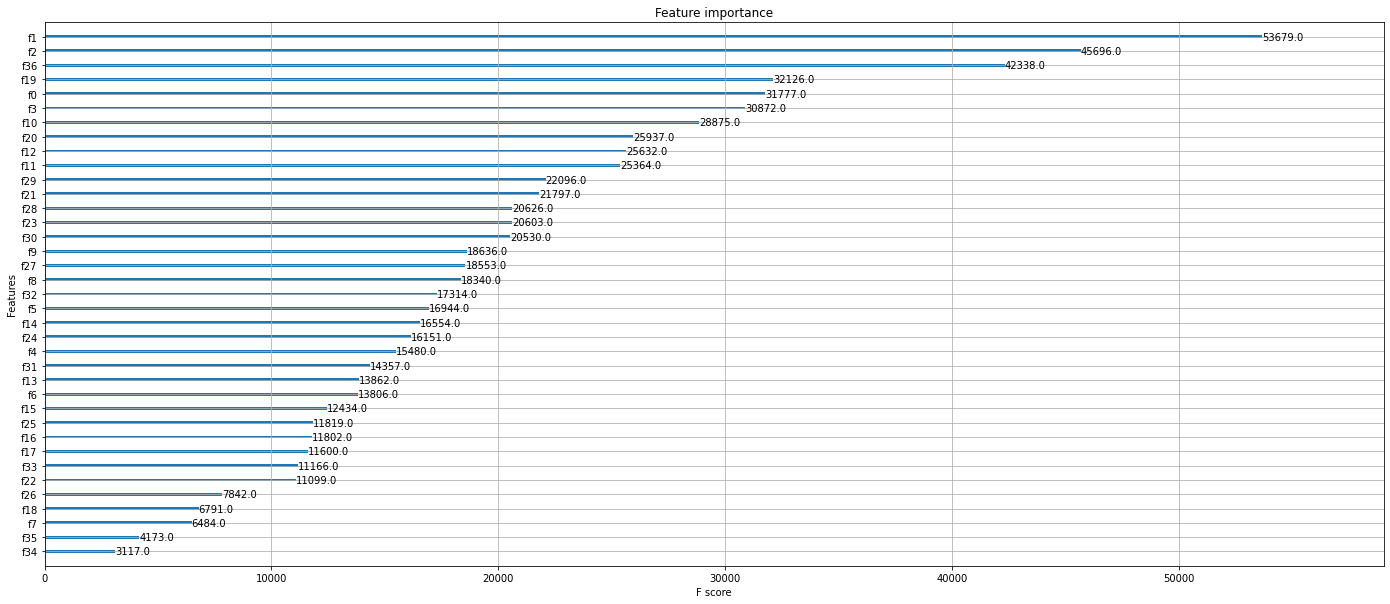

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (24, 10)

plot_importance(model)

Now, prediction

In [10]:
yhat_test = model.predict(X_test).clip(0,20)
ids = np.arange(0, X_test.shape[0],1)
ids.shape, X_test.shape

((214200,), (214200, 37))

In [12]:
# write the prediction to submission_mert_kurttutan.cs
with open('submission_mert_kurttutan.csv', 'w') as file:
  file.write("ID,item_cnt_month\n")
  for i in range(X_test.shape[0]):
    file.write(f"{i},{yhat_test[i]}\n")